Inferring demography and mutation spectrum history for human populations
==
- Plots using nextflow pipeline output in `output/` directory

In [1]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import tensorly
from tensorly.decomposition import non_negative_parafac
import pandas as pd

mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

/net/gs/vol1/home/wsdewitt/miniconda3/envs/1KG/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


Take a look at FIN

In [ ]:
# ksfs = pickle.load(open('output/europulse_mushi/EUR_FIN/dat.pkl', 'rb'))[-2]

# # plt.figure(figsize=(3, 3))
# # ksfs.clear_eta()
# # ksfs.infer_eta(ksfs.mu0, (0, 1e2), (2, 1e-2), ridge_penalty=1e-4, max_iter=1000, pts=200,
# #                trend_kwargs=dict(max_iter=100), verbose=True)
# # ksfs.eta.plot(t_gen=t_gen)
# # plt.xlim(1e3, 1e6);
# # plt.ylim(1e4, 1e6);
# # ksfs.loss()

# ksfs.clear_mu()
# ksfs.infer_mush((0, 5e1), (3, 1e-2), rank_penalty=1e2, ridge_penalty=1e-4, max_iter=100,
#                trend_kwargs=dict(max_iter=20), verbose=True)

# plt.figure(figsize=(3, 3))
# ksfs.mu.plot(('TCC>TTC',), t_gen=t_gen)
# ksfs.mu.plot(t_gen=t_gen, alpha=.2)
# plt.xlim(1e3, 1e6);
# # plt.ylim(1e4, 1e6);
# # ksfs.loss()

In [3]:
t_gen = 29

## $\eta$ parameter sweep for CEU population

In [4]:
sweep_data = defaultdict(list)

for i, f in enumerate(glob.glob('output/eta_sweep/*/EUR_CEU/dat*')):
    alpha_params, beta_params, ksfs, population = pickle.load(open(f, 'rb'))
    k, λ = alpha_params[0]
    sweep_data[k].append([λ, ksfs.loss(), ksfs])

# delta loss
for k in sorted(sweep_data):
    sweep_data[k] = np.array(sorted(sweep_data[k]))
    sweep_data[k][:, 1] = sweep_data[k][:, 1] - sweep_data[k][0, 1]

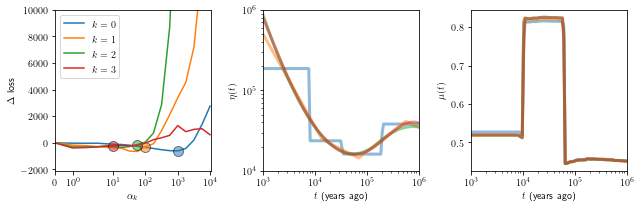

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for k in range(4):
    
    plt.sca(axes[0])
    λs, losss, ksfss = sweep_data[k].T
    plt.plot(λs, losss, label=f'$k={k}$')
    
    for λ, loss, ksfs in zip(λs, losss, ksfss):
        if (k, λ) in ((0, λs[13]), (1, λs[9]), (2, λs[8]), (3, λs[5])):

            plt.sca(axes[0])
            plt.plot(λ, loss, alpha=0.5, marker='o', color=f'C{k}', markeredgecolor='k', ms=10)

            plt.sca(axes[1])
            ksfs.eta.plot(t_gen=t_gen, alpha=0.5, lw=3, color=f'C{k}')
            
            plt.sca(axes[2])
            ksfs.mu.plot(('TCC>TTC', ), t_gen=t_gen, alpha=0.5, lw=3, color=f'C{k}')

plt.sca(axes[0])
plt.xlabel(r'$\alpha_k$')
plt.ylabel(r'$\Delta$ loss')
plt.xscale('symlog')
plt.ylim(None, 1e4)
# plt.yscale('symlog')
plt.legend()


plt.sca(axes[0])
plt.xlim(0, None)
plt.sca(axes[1])
plt.xlim(1e3, 1e6)
plt.ylim(1e4, 1e6)
plt.sca(axes[2])
plt.xlim(1e3, 1e6)

plt.tight_layout()
plt.savefig('plots/eta_sweep.pdf')

## $\boldsymbol\mu$ parameter sweep for CEU population

In [6]:
sweep_data = defaultdict(list)

for i, f in enumerate(glob.glob('output/mu_sweep/*/EUR_CEU/dat*')):
    alpha_params, beta_params, ksfs, population = pickle.load(open(f, 'rb'))
    k, λ = beta_params[0]
    sweep_data[k].append([λ, ksfs.loss(), ksfs])

# delta loss
for k in sorted(sweep_data):
    sweep_data[k] = np.array(sorted(sweep_data[k]))
    sweep_data[k][:, 1] = sweep_data[k][:, 1] - sweep_data[k][0, 1]

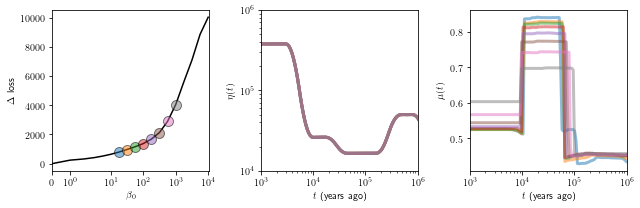

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for k in (0,): #range(4):
    
    plt.sca(axes[0])
    λs, losss, ksfss = sweep_data[k].T
    plt.plot(λs, losss, label=f'$k={k}$', c='k')
    
    for λ, loss, ksfs in zip(λs, losss, ksfss):
        if 1e1 < λ < 1.5e3:

            plt.sca(axes[0])
            plt.plot(λ, loss, alpha=0.5, marker='o', ms=10, markeredgecolor='k')#, color=f'C{k}')

            plt.sca(axes[1])
            ksfs.eta.plot(t_gen=t_gen, alpha=0.5, lw=3)#, color=f'C{k}')
            
            plt.sca(axes[2])
            ksfs.mu.plot(('TCC>TTC', ), t_gen=t_gen, alpha=0.5, lw=3)#, color=f'C{k}')

plt.sca(axes[0])
plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\Delta$ loss')
plt.xscale('symlog')
# plt.ylim(None, 4e3)
# plt.yscale('symlog')
# plt.legend()


plt.sca(axes[0])
plt.xlim(0, None)
plt.sca(axes[1])
plt.xlim(1e3, 1e6)
plt.ylim(1e4, 1e6)
plt.sca(axes[2])
plt.xlim(1e3, 1e6)

plt.tight_layout()
plt.savefig('plots/mu_sweep.pdf')

## Point estimates for TCC pulse
- Make a tidy plot with the regularization parameters indicated by points in previous plots
- Use all EUR populations

Tennessen


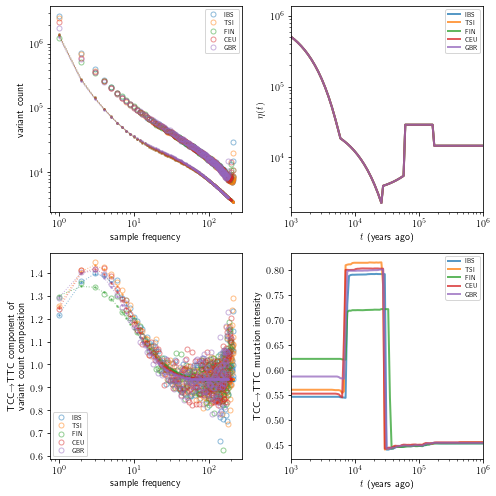

Relate


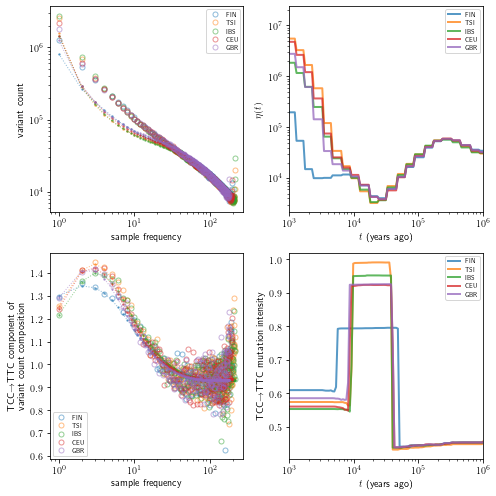

mushi


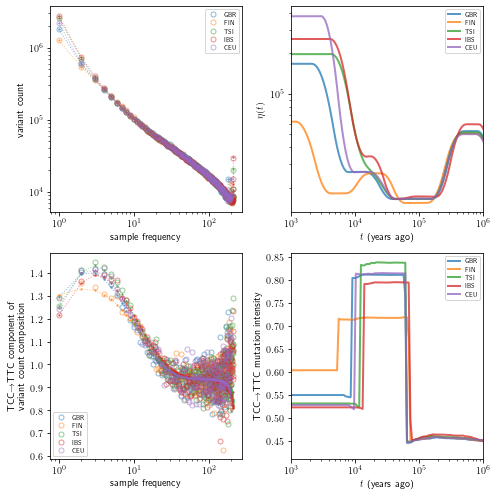

In [8]:
for method in ('Tennessen', 'Relate', 'mushi'):
    print(method)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

    files = glob.glob(f'output/europulse_{method}/*/dat.pkl')
    for idx, file in enumerate(files):
        pop = file.split('/')[2].split('_')[1]
        beta_params, ksfs, population = pickle.load(open(file, 'rb'))[-3:]

        plt.sca(axes[0, 0])
        ksfs.plot_total(kwargs=dict(ls='', alpha=0.5, marker='o', ms=5, mfc='none', c=f'C{idx}', label=pop, rasterized=True),
                        line_kwargs=dict(c=f'C{idx}', ls=':', marker='.', ms=3, alpha=0.5, lw=1, rasterized=True),
                        fill_kwargs=dict(color=f'C{idx}', alpha=0))
        plt.xscale('log')
        plt.yscale('log')
        plt.legend(fontsize=6, loc='upper right')
        if idx < len(files) - 1:
            plt.xlabel(None)

        plt.sca(axes[0, 1])
        ksfs.eta.plot(t_gen=t_gen, lw=2, label=pop, alpha=0.75, c=f'C{idx}')
        plt.xlim([1e3, 1e6])
        plt.legend(fontsize=6, loc='upper right')
        if idx < len(files) - 1:
            plt.xlabel(None)

        plt.sca(axes[1, 0])
        ksfs.plot(('TCC>TTC',), clr=True,
                  kwargs=dict(ls='', c=f'C{idx}', marker='o', ms=5, mfc='none', alpha=0.5, label=pop, rasterized=True),
                  line_kwargs=dict(c=f'C{idx}', ls=':', marker='.', ms=3, alpha=0.5, lw=1, rasterized=True))
        plt.ylabel('TCC$\\to$TTC component of\nvariant count composition')
        plt.legend(fontsize=6)

        plt.sca(axes[1, 1])
        plt.gca().set_prop_cycle(None)
        ksfs.mu.plot(('TCC>TTC',), t_gen=t_gen, clr=False, c=f'C{idx}', alpha=0.75, lw=2, label=pop)
        plt.ylabel('TCC$\\to$TTC mutation intensity')
        plt.xlim([1e3, 1e6])
        plt.legend(fontsize=6)

    plt.tight_layout()
    plt.savefig(f'plots/europulse_{method}.pdf')
    plt.show()

## Inferring $\eta$ from unfolded SFS for each population

In [9]:
files = glob.glob('output/mush/*/dat.pkl')

ksfs_dict = {}
pops = defaultdict(list)

for file in files:
    super_pop, pop = file.split('/')[2].split('_')
    alpha_params, beta_params, ksfs, population = pickle.load(open(file, 'rb'))
    pops[super_pop].append(pop)
    ksfs_dict[pop] = ksfs

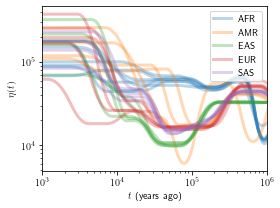

In [10]:
fig = plt.figure(figsize=(4, 3))
for idx_super, super_pop in enumerate(sorted(pops)):
    for idx, pop in enumerate(reversed(pops[super_pop])):
        ksfs_dict[pop].eta.plot(t_gen=t_gen, lw=3, label=super_pop if idx == 0 else None, alpha=0.3, c=f'C{idx_super}')
        plt.xlim([1e3, 1e6])
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig('plots/etas.pdf')

## Inferring $\eta$ from folded SFS for each population

In [11]:
files = glob.glob('output/mush_folded/*/dat.pkl')

ksfs_dict = {}
pops = defaultdict(list)

for file in files:
    super_pop, pop = file.split('/')[2].split('_')
    alpha_params, beta_params, ksfs, population = pickle.load(open(file, 'rb'))
    pops[super_pop].append(pop)
    ksfs_dict[pop] = ksfs

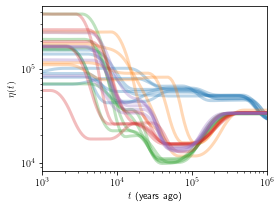

In [12]:
fig = plt.figure(figsize=(4, 3))
for idx_super, super_pop in enumerate(sorted(pops)):
    for idx, pop in enumerate(reversed(pops[super_pop])):
        ksfs_dict[pop].eta.plot(t_gen=t_gen, lw=3, label=super_pop if idx == 0 else None, alpha=0.3, c=f'C{idx_super}')
        plt.xlim([1e3, 1e6])
plt.tight_layout()
plt.savefig('plots/etas_folded.pdf')

Same as above, stratified by super-population, and including SFS fit

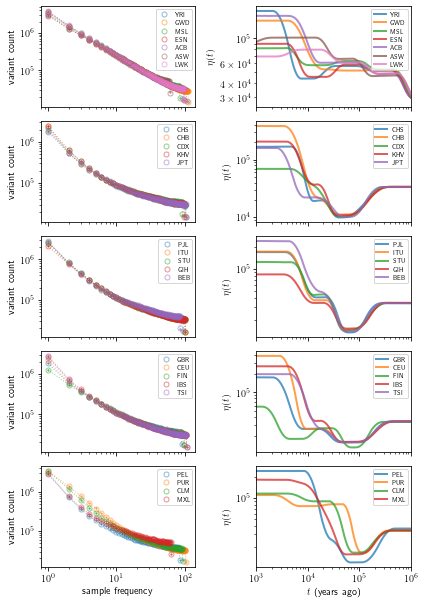

In [13]:
fig, axes = plt.subplots(len(pops), 2, sharex='col', figsize=(6, 1.7 * len(pops)), squeeze=False)
for idx_super, super_pop in enumerate(pops):
    for idx, pop in enumerate(pops[super_pop]):
        plt.sca(axes[idx_super, 0])
        ksfs_dict[pop].plot_total(folded=True,
                                  kwargs=dict(ls='', alpha=0.5, marker='o', ms=5, mfc='none', c=f'C{idx}', label=pop, rasterized=True),
                                  line_kwargs=dict(c=f'C{idx}', ls=':', marker='.', ms=3, alpha=0.5, lw=1, rasterized=True),
                                  fill_kwargs=dict(color=f'C{idx}', alpha=0))
        plt.xscale('log')
        plt.yscale('log')
        plt.legend(fontsize=6, loc='upper right')
        if idx_super < len(pops) - 1:
            plt.xlabel(None)
        plt.sca(axes[idx_super, 1])
        ksfs_dict[pop].eta.plot(t_gen=t_gen, lw=2, label=pop, alpha=0.75, c=f'C{idx}')
        plt.xlim([1e3, 1e6])
        plt.legend(fontsize=6, loc='upper right')
        if idx_super < len(pops) - 1:
            plt.xlabel(None)
plt.tight_layout()
plt.savefig('plots/sfsetas.pdf')

## $k$-SFS and inferred $\boldsymbol\mu$

AFR LWK


TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

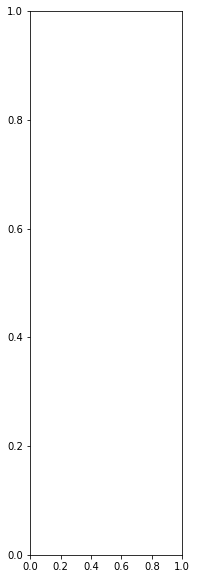

In [14]:
with mpl.rc_context(rc={'text.usetex': False}):
    for idx_super, super_pop in enumerate(sorted(pops)):
        for idx, pop in enumerate(reversed(pops[super_pop])):
            print(super_pop, pop)
            
            plt.figure(figsize=(6, 10))
            plt.subplot(121)
            ksfs_dict[pop].plot(clr=True, kwargs=dict(alpha=0.25, ls='', marker='o',
                                                      ms=3, mfc='none', rasterized=True),
                                line_kwargs=dict(ls=':', marker='.', ms=2, alpha=0.25,
                                                 lw=1, rasterized=True))
            plt.ylabel('variant count composition')
            plt.subplot(122)
            ksfs_dict[pop].μ.plot(t_gen=t_gen, clr=True, alpha=0.5, lw=2)
            plt.xscale('log')
            plt.ylabel('mutation intensity composition')
            plt.xlim([1e3, 1e6])
            plt.show()

            singlets = [f'{anc}>{der}' for anc, der in zip(ksfs_dict[pop].mutation_types.str[1],
                                                           ksfs_dict[pop].mutation_types.str[5])]

            ksfs_dict[pop].mutation_types.str[1].str.cat(ksfs_dict[pop].mutation_types.str[5], sep='>')

            pal = sns.color_palette('husl', n_colors=6)
            col_map = {'A>C': pal[0], 'A>G': pal[1], 'A>T': pal[2], 'C>A': pal[3], 'C>G': pal[4], 'C>T': pal[5]}
            col_colors = [col_map[singlet] for singlet in singlets]

            ksfs_dict[pop].clustermap(figsize=(20, 7), col_cluster=False,
                                      xticklabels=True, rasterized=True,
                                      robust=True, cmap='RdBu_r',
                                      col_colors=col_colors)
            plt.show()

            ksfs_dict[pop].μ.clustermap(t_gen=t_gen,
                                        figsize=(20, 7), col_cluster=False, xticklabels=True, rasterized=True,
                                        robust=True, cmap='RdBu_r',
                                        col_colors=col_colors)
            plt.show()

            # just first pop from each superpop
            break
        # break after first superpop
        break

## Tensor decomposition and mutation signature dynamics
### Non-negative CP decomposition

Stack the MuSHs for each population, scaled to site-wise rates, to form a tensor of order 3

In [15]:
sorted_triplets = [f'{a5}{a}{a3}>{a5}{d}{a3}' for a in 'AC' for d in 'ACGT' if d != a for a5 in 'ACGT' for a3 in 'ACGT']
masked_genome_size = pd.read_csv('output/masked_size.tsv', sep='\t', header=None, index_col=0, names=('count',))
targets = np.array([masked_genome_size.loc[triplet.split('>')[0], 'count'] for triplet in sorted_triplets])

Z = np.concatenate([(ksfs_dict[pop].mu.Z / targets)[np.newaxis, :, :]
                    for super_pop in sorted(pops)
                    for pop in reversed(pops[super_pop])], 0)

NNCP decomposition to extract factors for each dimension: sample, time, and mutation type. We try a range of ranks and assess reconstruction error at each.

rank 1 decomposition, error = 0.029497879918572223
rank 2 decomposition, error = 0.027917622133440644
rank 3 decomposition, error = 0.025552780361893478
rank 4 decomposition, error = 0.025349484966130098
rank 5 decomposition, error = 0.02493044528854023
rank 6 decomposition, error = 0.024660740605135244
rank 7 decomposition, error = 0.024451446920762933
rank 8 decomposition, error = 0.024385879143481948


/net/gs/vol1/home/wsdewitt/miniconda3/envs/1KG/lib/python3.7/site-packages/tensorly/backend/core.py:780: RuntimeWarning: divide by zero encountered in true_divide
  V = np.dot(matrix.T.conj(), U * np.where(np.abs(S) <= np.finfo(S.dtype).eps, 0, 1/S)[None, :])


rank 9 decomposition, error = 0.024064138291104153
rank 10 decomposition, error = 0.024016663230408464


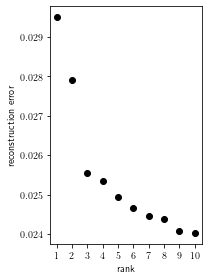

In [16]:
ranks = range(1, 11)
errors = []
tensors = {}
for rank in ranks:
    # NOTE: normalize_factors=True leads to instability for some reason
    tensor, error = non_negative_parafac(Z, rank=rank,
                                         orthogonalise=False, normalize_factors=False,
                                         tol=1e-7, n_iter_max=1000, cvg_criterion='rec_error',
                                         random_state=0, return_errors=True)
    print(f'rank {rank} decomposition, error = {error[-1]}')
    errors.append(error[-1])
    tensors[rank] = tensor[1]

plt.figure(figsize=(3, 4))
plt.plot(ranks, errors, 'ko')
plt.xlabel('rank')
plt.xticks(ranks)
plt.ylabel('reconstruction error')
plt.tight_layout()
plt.savefig('plots/elbow.pdf')

Choose rank

In [23]:
rank = 5
factors_sample, factors_history, factors_signature = tensors[rank]

### Project the sample dimension factors to two principal components

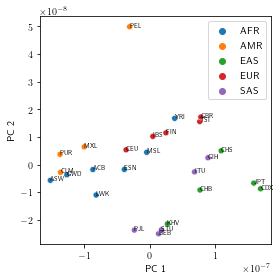

In [24]:
x, y = PCA(n_components=2).fit_transform(factors_sample).T
plt.figure(figsize=(4, 4))
sns.scatterplot(x=x, y=y, hue=[super_pop for super_pop in sorted(pops)
                               for pop in reversed(pops[super_pop])])
i = 0
for super_pop in sorted(pops):
    for pop in reversed(pops[super_pop]):
        plt.annotate(pop, (x[i], y[i]), size=6)
        i += 1
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.tight_layout()
plt.savefig('plots/factors_pop.pdf')

### Project the time dimension factors to two principal components

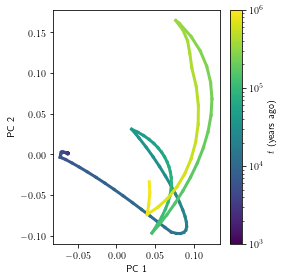

In [25]:
xy = PCA(n_components=2).fit_transform(factors_history)
idxs = (1e3 <= t_gen * ksfs_dict[pop].mu.arrays()[0][:-1]) & (t_gen * ksfs_dict[pop].mu.arrays()[0][:-1] <= 1e6)
plt.figure(figsize=(4, 4))
x = np.dstack((xy[idxs][:-1, 0], xy[idxs][1:, 0])).flatten()
y = np.dstack((xy[idxs][:-1, 1], xy[idxs][1:, 1])).flatten()
z = t_gen * np.dstack((ksfs_dict[pop].mu.arrays()[0][:-1][idxs][:-1], ksfs_dict[pop].mu.arrays()[0][:-1][idxs][:-1])).flatten()
norm = mpl.colors.LogNorm(vmin=1e3, vmax=1e6)
points = plt.scatter(x=x, y=y, c=z, s=0, norm=norm, cmap='viridis')
sns.lineplot(x=x, y=y, hue=z, hue_norm=norm, lw=3, legend=False, palette='viridis')
cbar= plt.colorbar(points)
cbar.set_label('$t$ (years ago)', rotation=90)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.tight_layout()
plt.savefig('plots/factors_history.pdf')

### Project the mutation type dimension factors to two principal components

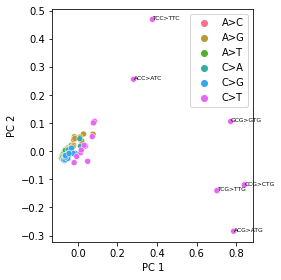

In [26]:
with mpl.rc_context(rc={'text.usetex': False}):
    singlets = [f'{anc}>{der}' for anc, der in zip(ksfs_dict[pop].mutation_types.str[1],
                                                   ksfs_dict[pop].mutation_types.str[5])]
    x, y = PCA(n_components=2).fit_transform(factors_signature).T
    plt.figure(figsize=(4, 4))
    sns.scatterplot(x=x, y=y, hue=singlets, palette='husl')
    for i, mutation_type in enumerate(ksfs_dict[pop].mu.mutation_types):
        if np.abs([x[i], y[i]]).max() > 0.15:
            plt.annotate(mutation_type, (x[i], y[i]), size=6)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.tight_layout()
    plt.savefig('plots/factors_mutation.pdf')

### Display mutation type loadings as mutation signatures

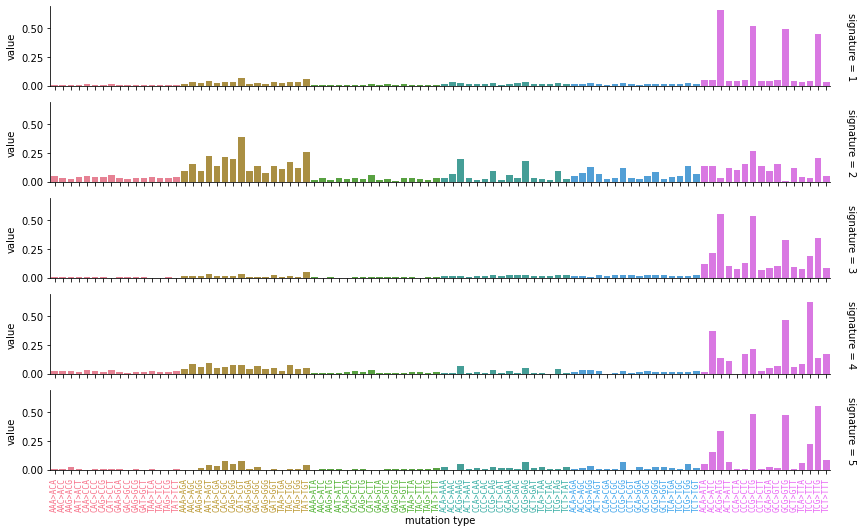

In [27]:
signature_df = pd.DataFrame(factors_signature,
                            columns=[i for i in range(1, factors_signature.shape[1] + 1)])
signature_df['mutation type'] = ksfs_dict[pop].mu.mutation_types
signature_df['singlet type'] = singlets

pal = sns.color_palette('husl', n_colors=6)
colors = {'A>C': pal[0], 'A>G': pal[1], 'A>T': pal[2],
          'C>A': pal[3], 'C>G': pal[4], 'C>T': pal[5]}
palette = [colors[singlet] for singlet in signature_df['singlet type']]
signature_df = signature_df.melt(id_vars=['mutation type', 'singlet type'], var_name='signature')

with mpl.rc_context(rc={'text.usetex': False}):
    g = sns.FacetGrid(signature_df, row='signature', aspect=8, height=1.5,
                      margin_titles=True, sharey=True)
    g = g.map(sns.barplot, 'mutation type', 'value',
              order=ksfs_dict[pop].mu.mutation_types,
              palette=palette)
    g.set_xticklabels(rotation=90, fontsize=8, family='monospace')
    for xtick, color in zip(g.axes.flat[-1].get_xticklabels(), palette):
        xtick.set_color(color)
    plt.tight_layout()
    plt.savefig('plots/signatures.pdf')

### Mutation signature dynamics in each population

- rows correspond to mutation signatures
- columns correspond to super populations

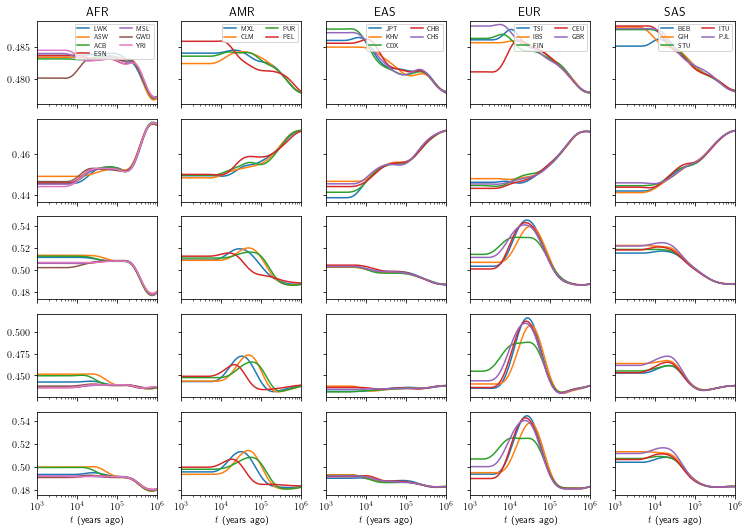

In [28]:
factors_signature_normed = factors_signature * targets[:, np.newaxis]
factors_signature_normed /= factors_signature_normed.sum(0, keepdims=True)

Z_transform = tensorly.tenalg.mode_dot(Z * targets[np.newaxis, np.newaxis, :], factors_signature_normed.T, mode=2)

fig, axes = plt.subplots(Z_transform.shape[2], len(pops), sharex=True, sharey='row', figsize=(2.1 * len(pops), 1.5 * Z_transform.shape[2]))
for k in range(Z_transform.shape[2]):
    i = 0
    for idx, super_pop in enumerate(sorted(pops)):
        plt.sca(axes[k, idx])
        for idx2, pop in enumerate(reversed(pops[super_pop])):
            plt.plot(t_gen * ksfs_dict[pop].mu.arrays()[0][:-1], Z_transform[i, :, k],
                     label=pop)
            plt.xscale('log')
            plt.xlim([1e3, 1e6])
            i += 1
        if k == 0:
            plt.title(super_pop)
            plt.legend(fontsize=6, loc='upper right', ncol=2)
        elif k == Z_transform.shape[2] - 1:
            plt.xlabel('$t$ (years ago)')
plt.tight_layout()
plt.savefig('plots/signature_histories.pdf')

The same histories overlayed for all populations

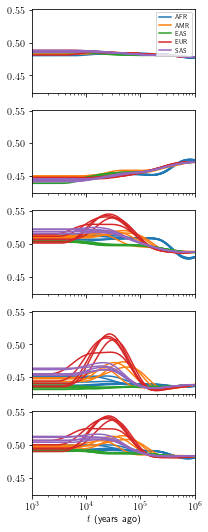

In [29]:
fig, axes = plt.subplots(Z_transform.shape[2], 1, sharex=True, sharey=True, figsize=(3, 1.5 * Z_transform.shape[2]))
for k in range(Z_transform.shape[2]):
    i = 0
    plt.sca(axes[k])
    for idx, super_pop in enumerate(sorted(pops)):
        for idx2, pop in enumerate(reversed(pops[super_pop])):
            plt.plot(t_gen * ksfs_dict[pop].mu.arrays()[0][:-1], Z_transform[i, :, k],
                     label=(super_pop if idx2 == 0 else None), c=f'C{idx}')
            plt.xscale('log')
            plt.xlim([1e3, 1e6])
            i += 1
    if k == 0:
        plt.legend(fontsize=6, loc='upper right')
plt.xlabel('$t$ (years ago)')
plt.tight_layout()
plt.savefig('plots/signature_histories_all.pdf')

## Global divergence in mutation spectra

### UMAP embedding of mutation signatures through time for all populations

In [30]:
time = t_gen * np.concatenate(([0], ksfs_dict[pop].μ.change_points))
time_mask = ((1e3 <= time) & (time <= 1e6))

np.random.seed(1)

embedding_init = PCA(n_components=2)
embedding_init.fit(factors_history[time_mask, :])

colors = {super_pop: f'C{idx}' for idx, super_pop in enumerate(sorted(pops))}

Z_dict = {}
i = 0
for super_pop in sorted(pops):
    for pop in reversed(pops[super_pop]):
        Z_dict[pop] = Z_transform[i, time_mask, :]
        i += 1

Z_stack = np.concatenate([Z_dict[pop] for super_pop in pops for pop in pops[super_pop]])
embedding = umap.UMAP(n_components=2,
                      n_epochs=1000,
                      init=embedding_init.transform(Z_stack),
                      random_state=1)
embedding.fit(Z_stack)


Z_transform_dict = {pop: embedding.transform(Z_dict[pop])
                    for super_pop in pops
                    for pop in pops[super_pop]}

inside function
   (0, 0)	1.0
  (0, 1)	0.8100503
  (0, 2)	0.6482025
  (0, 3)	0.5145096
  (0, 4)	0.40621772
  (0, 5)	0.32156888
  (0, 6)	0.25504583
  (0, 7)	0.20529832
  (0, 8)	0.16837001
  (0, 9)	0.14093414
  (0, 10)	0.119850144
  (0, 11)	0.102576606
  (0, 12)	0.08689698
  (0, 13)	0.07152177
  (0, 14)	0.055843018
  (1, 0)	0.7742606
  (1, 1)	1.0
  (1, 2)	0.7627766
  (1, 3)	0.57616913
  (1, 4)	0.4324051
  (1, 5)	0.32552764
  (1, 6)	0.24562648
  (1, 7)	0.18863644
  (1, 8)	0.14815553
  (1, 9)	0.119212665
  :	:
  (111, 112)	0.29260522
  (111, 224)	0.15621714
  (111, 338)	0.20893078
  (111, 446)	0.19109029
  (111, 447)	0.24326654
  (111, 448)	0.31591967
  (111, 449)	0.4773859
  (111, 450)	0.45564714
  (111, 451)	0.16287279
  (111, 790)	0.26832348
  (112, 106)	0.2110901
  (112, 107)	0.18028247
  (112, 110)	0.22210786
  (112, 111)	0.41306737
  (112, 112)	1.0
  (112, 224)	0.18062423
  (112, 225)	0.29149517
  (112, 445)	0.18694352
  (112, 446)	0.19269751
  (112, 447)	0.18375821
  (112, 448)	0.20

inside function
   (0, 904)	1.0
  (0, 905)	0.74339503
  (0, 906)	0.55484706
  (0, 907)	0.4297179
  (0, 908)	0.34673038
  (0, 909)	0.30226347
  (0, 910)	0.27829456
  (0, 911)	0.2647046
  (0, 912)	0.24487178
  (0, 913)	0.20368044
  (0, 914)	0.15566382
  (0, 915)	0.11934376
  (0, 916)	0.0994056
  (0, 917)	0.09296467
  (0, 918)	0.07101255
  (1, 904)	0.69876796
  (1, 905)	1.0
  (1, 906)	0.70102245
  (1, 907)	0.5134217
  (1, 908)	0.39418426
  (1, 909)	0.32962728
  (1, 910)	0.290157
  (1, 911)	0.25856197
  (1, 912)	0.21608223
  (1, 913)	0.15782988
  :	:
  (111, 1127)	0.12995121
  (111, 1128)	0.36828196
  (111, 1129)	0.37680855
  (111, 1242)	0.2509132
  (111, 1468)	0.23095654
  (111, 1581)	0.1426688
  (111, 1693)	0.16367894
  (111, 1694)	0.26493508
  (111, 1806)	0.27290046
  (111, 1807)	0.5522848
  (112, 902)	0.16457775
  (112, 903)	0.23743385
  (112, 1014)	0.25535434
  (112, 1015)	0.54236573
  (112, 1016)	1.0
  (112, 1128)	0.31637207
  (112, 1129)	0.52036554
  (112, 1242)	0.21669735
  (112, 1

inside function
   (0, 1695)	1.0
  (0, 1696)	0.7851216
  (0, 1697)	0.6177333
  (0, 1698)	0.49178967
  (0, 1699)	0.39972687
  (0, 1700)	0.33438325
  (0, 1701)	0.2759111
  (0, 1702)	0.22819863
  (0, 1703)	0.18517707
  (0, 1704)	0.1456245
  (0, 1705)	0.113136165
  (0, 1706)	0.09246819
  (0, 1707)	0.082830876
  (0, 1708)	0.08012575
  (0, 1709)	0.074667074
  (1, 1695)	0.74582934
  (1, 1696)	1.0
  (1, 1697)	0.7466688
  (1, 1698)	0.5646101
  (1, 1699)	0.43694398
  (1, 1700)	0.34828314
  (1, 1701)	0.27058572
  (1, 1702)	0.20950142
  (1, 1703)	0.15747231
  (1, 1704)	0.11415189
  :	:
  (111, 1128)	0.27884775
  (111, 1241)	0.1832466
  (111, 1242)	0.28592962
  (111, 1467)	0.34147337
  (111, 1468)	0.5441049
  (111, 1693)	0.23187537
  (111, 1694)	0.20844728
  (111, 1805)	0.22939925
  (111, 1806)	1.0
  (111, 1807)	0.30000004
  (112, 903)	0.17768003
  (112, 1014)	0.37794012
  (112, 1015)	0.5212617
  (112, 1016)	0.23979555
  (112, 1127)	0.1610119
  (112, 1128)	0.3948186
  (112, 1129)	0.25601614
  (112,

inside function
   (0, 2486)	1.0
  (0, 2487)	0.74141705
  (0, 2488)	0.5413231
  (0, 2489)	0.39569008
  (0, 2490)	0.3001215
  (0, 2491)	0.24750021
  (0, 2492)	0.23386006
  (0, 2493)	0.2568537
  (0, 2494)	0.31925988
  (0, 2495)	0.36372223
  (0, 2496)	0.2453691
  (0, 2497)	0.10450814
  (0, 2502)	0.04031133
  (0, 2503)	0.067134775
  (0, 2511)	0.049814984
  (1, 2486)	0.6943837
  (1, 2487)	1.0
  (1, 2488)	0.68068874
  (1, 2489)	0.4647302
  (1, 2490)	0.3318958
  (1, 2491)	0.2624303
  (1, 2492)	0.24459295
  (1, 2493)	0.27184656
  (1, 2494)	0.33714288
  (1, 2495)	0.32477757
  :	:
  (111, 1917)	0.1856932
  (111, 1918)	0.18699966
  (111, 1919)	0.18213752
  (111, 2033)	0.18813959
  (111, 2146)	0.19079438
  (111, 2594)	0.24989231
  (111, 2595)	0.420174
  (111, 2596)	0.6672652
  (111, 2597)	1.0
  (111, 2598)	0.70657545
  (112, 1578)	0.20021214
  (112, 1579)	0.21477266
  (112, 1580)	0.22035047
  (112, 1581)	0.22019134
  (112, 1917)	0.20203604
  (112, 1918)	0.21375334
  (112, 1919)	0.21738714
  (112, 

### Plot embedding

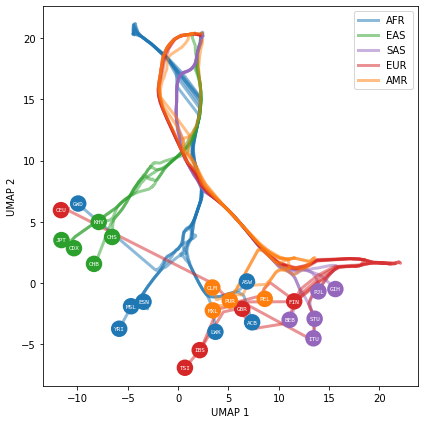

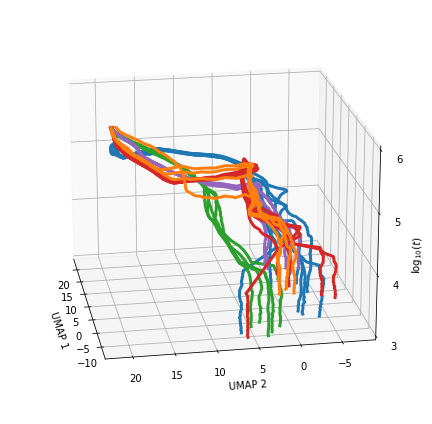

In [31]:
with mpl.rc_context(rc={'text.usetex': False}):

    plt.figure(figsize=(6, 6))
    # plt.subplot(311)
    for super_pop in pops:
        for idx2, pop in enumerate(pops[super_pop]):
            plt.plot(*Z_transform_dict[pop].T,
                     '-', lw=3, alpha=.5,
                     c=colors[super_pop],
                     label=super_pop if idx2 == 0 else None)
            plt.annotate(pop, Z_transform_dict[pop][0, :],
                         ha='center', va='center', c='w',
                         family='monospace',
                         bbox=dict(boxstyle='circle', fc=colors[super_pop], ec=colors[super_pop], lw=2),
                         size=6)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.tight_layout()
    plt.savefig('plots/umap.pdf')
    

    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca(projection='3d')
    ax.view_init(20, 170)
    for super_pop in pops:
        for pop in pops[super_pop]:
            ax.plot(*Z_transform_dict[pop].T, np.log10(time[time_mask]),
                    '-', lw=3, alpha=1,
                    c=colors[super_pop],
                    label=super_pop if idx2 == 0 else None)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_zlabel('$\log_{10}(t)$')
    ax.set_zticks([3, 4, 5, 6])
    ax.set_zlim([3, 6])
    plt.tight_layout()
    plt.savefig('plots/umap_3d.pdf')
